# Analyzing jazz recordings from the `Jazz-Trio-Database`
Author: [Huw Cheston](https://huwcheston.github.io)

This notebook walks through a few basic features for analyzing rhythm and timing in jazz, using data from the Jazz Trio Database [1]. The predictive modelling aspect is inspired by [2].

*References:*

[1] Cheston, H., Schlichting, J.L., Cross, I. and Harrison, P.M.C. (2024) Jazz Trio Database:
Automated Annotation of Jazz Piano Trio Recordings Processed Using Audio Source Separation.
Transactions of the International Society for Music Information Retrieval, 7/1 (pp. 144–158).

[2] Cheston, H., Schlichting, J. L., Cross, I., & Harrison, P. M. C. (2024). Rhythmic qualities of jazz
improvisation predict performer identity and style in source-separated audio recordings. Royal Society
Open Science. 11/11.

## Import dependencies, set constants

In [1]:
import os
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from zipfile import ZipFile

from musmart.timing.swing import beat_upbeat_ratio
from musmart.timing.tempo_modeling import tempo_slope, tempo_fluctuation, tempo_drift

Defined boundary as musmart.boundary in lazy_modules
Defined break_it_up as musmart.break_it_up in lazy_modules
Defined durdist1 as musmart.durdist1 in lazy_modules
Defined durdist2 as musmart.durdist2 in lazy_modules
Defined entropy as musmart.entropy in lazy_modules
Defined hz2midi as musmart.hz2midi in lazy_modules
Defined ismonophonic as musmart.ismonophonic in lazy_modules
Defined ivdirdist1 as musmart.ivdirdist1 in lazy_modules
Defined ivdist1 as musmart.ivdist1 in lazy_modules
Defined ivdist2 as musmart.ivdist2 in lazy_modules
Defined ivsizedist1 as musmart.ivsizedist1 in lazy_modules
Defined nnotes as musmart.nnotes in lazy_modules
Defined pcdist1 as musmart.pcdist1 in lazy_modules
Defined pcdist2 as musmart.pcdist2 in lazy_modules
Defined pc_set_functions as musmart.pc_set_functions in lazy_modules
Defined pitchmean as musmart.pitchmean in lazy_modules
Defined pitch_list_transformations as musmart.pitch_list_transformations in lazy_modules
Defined pitch_mean as musmart.pitch_m

In [2]:
# This notebook requires statsmodels to create a predictive model
# This is NOT part of the current installation of the package
import statsmodels.api as sm

## Pull data from JTD

We need to download the JTD data first. This consists of multiple recordings, with each recording containing onset timestamps for the piano instrument. 

These are split into `beats`, which are those onsets which can be matched with a timestamp from an external beat tracker, and `onsets`, which is just every onset regardless of if it can be matched.

In [3]:
url = "https://github.com/HuwCheston/Jazz-Trio-Database/releases/download/v02/jazz-trio-database-v02.zip" 
zip_file_path = "jtd.zip"
# Download the file
response = requests.get(url)
with open(zip_file_path, "wb") as file:
    file.write(response.content)# Ensure it exists
# Extract the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("")

## Get data from target performers
We'll get data for tracks by Bill Evans and Oscar Peterson.

For our purposes, we can also split `onsets` into `upbeats`, which are those onsets *not* contained in `beats`.

In [4]:
def load_data(track_loc: str) -> tuple[np.ndarray, np.ndarray]:
    """Given the name of a track, return arrays of piano beats and piano onsets"""
    # Define names of csv files
    beats_file = os.path.join(os.getcwd(), 'jazz-trio-database-v02', track_loc, 'beats.csv')
    onsets_file = os.path.join(os.getcwd(), 'jazz-trio-database-v02', track_loc, 'piano_onsets.csv')
    # Load csv files into numpy arrays
    bea = np.genfromtxt(beats_file, delimiter=',')[1:, 2]    # this is the column for piano quarter notes
    onse = np.genfromtxt(onsets_file)
    # Split `onsets` into `upbeats` (i.e., every onset that doesn't mark a beat)
    upbea = onse[~np.isin(onse, bea)]
    return upbea, bea

In [5]:
evans_beats, evans_upbeats = [], []
peterson_beats, peterson_upbeats = [], []

for track_folder in os.listdir('jazz-trio-database-v02'):
    metadata_file = os.path.join(os.getcwd(), 'jazz-trio-database-v02', track_folder, 'metadata.json')
    if os.path.isfile(metadata_file):
        # Load the metadata json and get the name of the pianist
        metadata_loaded = json.load(open(metadata_file, 'r'))
        pianist = metadata_loaded['musicians']['pianist']
        # Load data for the pianists we want
        if pianist == "Bill Evans" or pianist == "Oscar Peterson":
            upbeat, beat = load_data(track_folder)
            # Append to required list
            if pianist == "Bill Evans":
                evans_beats.append(beat)
                evans_upbeats.append(upbeat)
            elif pianist == "Oscar Peterson":
                peterson_beats.append(beat)
                peterson_upbeats.append(upbeat)


## Plot features for a single track

Start by extracting beat-upbeat ratio

In [6]:
# Just use a single track
desired_beats, desired_upbeats = evans_beats[0], evans_upbeats[0]

In [10]:
# Calculate BUR for the first upbeat following each beat
burs = beat_upbeat_ratio(
    beats=desired_beats, 
    upbeats=desired_upbeats, 
    allow_multiple_burs_per_beat=False
)
# For simplicity, clean BURs between 0.25 and 4.0
burs = [b for b in burs if (0.25 < b < 4.)]

[0.631578947368421, 0.8823529411764706, 1.0769230769230762, 0.6666666666666652, 0.7857142857142898, 0.6666666666666683, 1.2499999999999982, 0.75, 0.866666666666669, 0.8666666666666639, 0.5, 0.6470588235294139, 0.8749999999999972, 0.9999999999999937, 0.6666666666666726, 0.8124999999999987, 0.8124999999999931, 0.9375000000000013, 0.3750000000000028, 0.9374999999999903, 0.8571428571428608, 1.3076923076922993, 0.7142857142857306, 2.3749999999999916, 2.222222222222218, 0.6470588235294191, 1.3333333333333255, 1.0, 0.7647058823529645, 0.6249999999999861, 0.7058823529411543, 0.7058823529411753, 0.8000000000000143, 0.5294117647058872, 2.374999999999917, 1.9999999999999645, 2.1111111111111285, 2.3750000000000666, 0.5000000000000089, 0.6111111111111089, 2.500000000000089, 0.4444444444444554, 0.5263157894736694, 0.5, 0.5263157894736694, 0.4736842105263207, 2.1111111111111285, 0.7142857142857046, 1.0909090909091055, 0.8000000000000143, 0.8124999999999931, 0.9333333333333239, 0.8000000000000143, 0.9

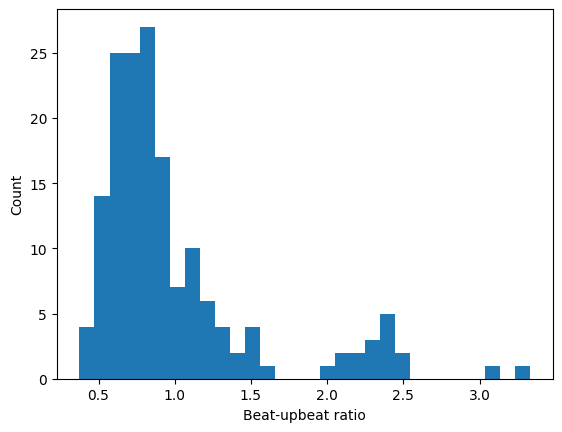

In [11]:
# Plot the BURs
plt.hist(burs, bins=30)
ax = plt.gca()
ax.set(xlabel='Beat-upbeat ratio', ylabel='Count')
plt.show()

Most BURs are around 1.0, but we also have peaks at 2.0 (i.e., "triplet 8ths") which is consistent with previous research

## Plot features for several tracks
We can plot the distribution of tempo slope values here

In [12]:
slopes = np.array([tempo_slope(b) for b in evans_beats])

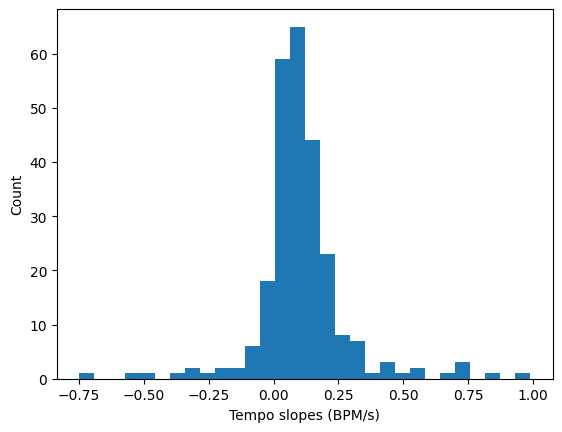

In [13]:
# Plot the slopes
plt.hist(slopes, bins=30)
ax = plt.gca()
ax.set(xlabel='Tempo slopes (BPM/s)', ylabel='Count')
plt.show()

Results are very clustered around 0 (i.e., no change in tempo), with a slight tendency towards acceleration. Again, this is consistent with previous work.

## Create dataset
We're going to extract the following features from each track
- Average BUR
- Standard deviation BUR
- Tempo slope
- Tempo drift
- Tempo fluctuation

and use these to predict whether a track is by Oscar Peterson or Bill Evans

In [15]:
def construct_features(track_upbeats: np.array, track_beats: np.array) -> np.array:
    """Given non-beat onsets and beat onsets for a track, construct features"""
    # Calculate BUR for the first upbeat following each beat
    burs = beat_upbeat_ratio(
        beats=track_beats, 
        upbeats=track_upbeats, 
        allow_multiple_burs_per_beat=False
    )
    # For simplicity, clean BURs between 0.25 and 4.0
    burs = [b for b in burs if (0.25 < b < 4.)]
    # Get mean and SD BUR
    mean_bur, sd_bur = np.nanmean(burs), np.nanstd(burs)
    # Get remaining tempo features
    slope = tempo_slope(track_beats)
    drift = tempo_drift(track_beats)
    fluct = tempo_fluctuation(track_beats)
    # Create vector of features
    return np.array([mean_bur, sd_bur, slope, drift, fluct])
    

In [16]:
performer_upbeats = [evans_upbeats, peterson_upbeats]
performer_beats = [evans_beats, peterson_beats]

features, targets = [], []
# Assign 0 to Evans, 1 to Peterson
for perf_idx in range(len(performer_upbeats)):
    # Iterate over every track by the current performer
    for perf_upbeat, perf_beat in zip(performer_upbeats[perf_idx], performer_beats[perf_idx]):
        x_vect = construct_features(perf_upbeat, perf_beat)
        # Append everything to lists
        features.append(x_vect)
        targets.append(perf_idx)    # 0 = Evans, 1 = Peterson
# Stack to create arrays for modeling
x = np.stack(features)    # (n_tracks, n_features)
y = np.array(targets)    # (n_tracks,)
assert x.shape[0] == y.shape[0]

TypeError: '<' not supported between instances of 'list' and 'int'

## Modelling
We'll start with creating a simple logistic regression here

In [12]:
# Scale the feature set using z-score
x_scale = np.apply_along_axis(stats.zscore, 0, x)
# Add a constant term to the model
x_const = sm.add_constant(x_scale)

In [ ]:
# Fit the model
md = sm.Logit(y, x_const).fit()
print(md.summary())

In [14]:
# Make predictions of training data
yhat = md.predict(x_const) 
prediction = list(map(round, yhat)) 
# Get accuracy as number of correct predictions
acc = sum([pred == actual for pred, actual in zip(prediction, y)]) / len(y)
acc

np.float64(0.8176943699731903)

OK, so we were correct approximately 82% of the times in classifying Oscar Peterson or Bill Evans tracks using these features